# Load in packages and data

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session

from functions import get_eff_faker_err, train_test_split_by_part, get_eff_faker_vs_feat

In [3]:
# Take in .root into arrays
arrays = (uproot.open("TTbar_PU200_D49_prompt.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

In [4]:
# A look at what variables you can use as inputs to your model
arrays.keys()

dict_keys(['trk_pt', 'trk_eta', 'trk_phi', 'trk_d0', 'trk_z0', 'trk_chi2', 'trk_chi2rphi', 'trk_chi2rz', 'trk_bendchi2', 'trk_nstub', 'trk_lhits', 'trk_dhits', 'trk_seed', 'trk_hitpattern', 'trk_phiSector', 'trk_genuine', 'trk_loose', 'trk_unknown', 'trk_combinatoric', 'trk_fake', 'trk_matchtp_pdgid', 'trk_matchtp_pt', 'trk_matchtp_eta', 'trk_matchtp_phi', 'trk_matchtp_z0', 'trk_matchtp_dxy', 'trk_injet', 'trk_injet_highpt', 'trk_injet_vhighpt', 'tp_pt', 'tp_eta', 'tp_phi', 'tp_dxy', 'tp_d0', 'tp_z0', 'tp_d0_prod', 'tp_z0_prod', 'tp_pdgid', 'tp_nmatch', 'tp_nloosematch', 'tp_nstub', 'tp_eventid', 'tp_charge', 'tp_injet', 'tp_injet_highpt', 'tp_injet_vhighpt', 'matchtrk_pt', 'matchtrk_eta', 'matchtrk_phi', 'matchtrk_z0', 'matchtrk_d0', 'matchtrk_chi2', 'matchtrk_chi2rphi', 'matchtrk_chi2rz', 'matchtrk_bendchi2', 'matchtrk_nstub', 'matchtrk_lhits', 'matchtrk_dhits', 'matchtrk_seed', 'matchtrk_hitpattern', 'matchtrk_injet', 'matchtrk_injet_highpt', 'matchtrk_injet_vhighpt', 'loosematchtrk

# Create train and test samples

In [5]:
# Select features from data and put in proper format
# 'trk_fake' is the track quality variable, truth data

features = ['trk_pt','trk_eta','trk_phi','trk_z0','trk_chi2rphi','trk_chi2rz','trk_bendchi2','trk_bendchi2']
X = np.empty((len(arrays[features[0]].flatten()),len(features)))
for i in range(len(features)):
    X[:,i] = arrays[features[i]].flatten()

y = arrays['trk_fake'].flatten()
y[y==2] = 1

# Grab pdgid for certain studies
pdgid = arrays['trk_matchtp_pdgid'].flatten()

In [6]:
# Get rid of any nan instances for training purposes (doesn't converge)
find_nan = np.argwhere(np.isnan(X))
X = np.delete(X, find_nan[:,0], 0)
y = np.delete(y, find_nan[:,0])
pdgid = np.delete(pdgid, find_nan[:,0])

In [7]:
# Create train and test sets with 2500 of each mu, elec, had, fake in train, rest in test
X_train, y_train, pdgid_train, X_test, y_test, pdgid_test = train_test_split_by_part(X,y,pdgid,2500,2500,2500,2500)

# Train neural network (NN)

In [8]:
clear_session()

In [9]:
# This creates NN with 2 hidden layers and one output layer
# The first hidden layer has 128 nodes, and the second has 64 nodes
# The output is a single node with a value between 0 and 1
# Visit https://keras.io/ for more information on how to configure NN
clf_NN = Sequential()
clf_NN.add(Dense(128, input_dim=len(features), activation='relu')) # each Dense layer is a fully-connected layer in the NN being added
clf_NN.add(Dense(64, activation='relu'))
clf_NN.add(Dense(1, activation='sigmoid'))
clf_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
clf_NN.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0) #verbose is supressing output

# Check NN performance

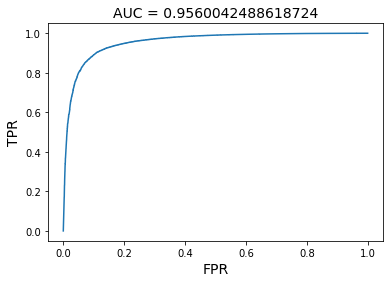

In [10]:
# Create roc curve with AUC (area under curve) value
y_pred = clf_NN.predict(X_test)[:,0]
fpr, tpr, dt = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.title('AUC = '+str(auc),fontsize=14)
plt.show()

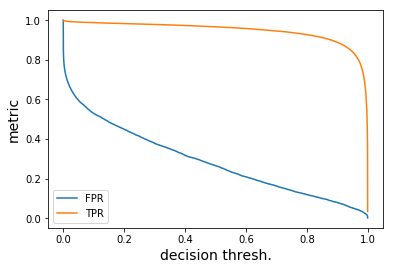

In [10]:
# Plot TPR and FPR vs decision threshold (dt)
plt.plot(dt[1:],fpr[1:],label='FPR')
plt.plot(dt[1:],tpr[1:],label='TPR')
plt.xlabel('decision thresh.',fontsize=14)
plt.ylabel('metric',fontsize=14)
plt.legend(loc='best')
plt.show()

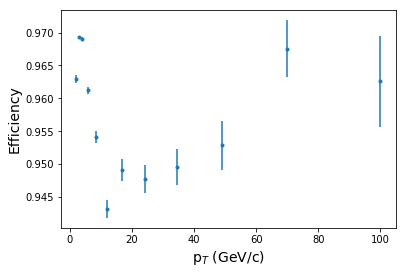

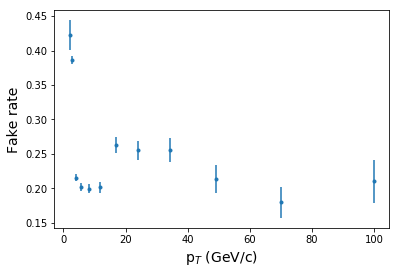

In [11]:
# Create efficiency/fake rate vs. pt
pt, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('pt',features,X_test,y_test,clf_NN)

plt.errorbar(pt,eff,yerr=err_eff,linestyle='None',fmt='.')
plt.xlabel('p$_{T}$ (GeV/c)',fontsize=14)
plt.ylabel('Efficiency',fontsize=14)
plt.show()

plt.errorbar(pt,faker,yerr=err_faker,linestyle='None',fmt='.')
plt.xlabel('p$_{T}$ (GeV/c)',fontsize=14)
plt.ylabel('Fake rate',fontsize=14)
plt.show()

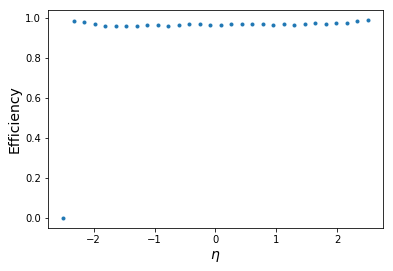

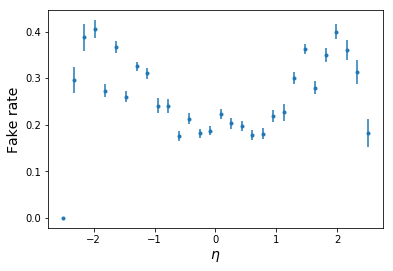

In [12]:
# Create efficiency/fake rate vs. eta
pt, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('eta',features,X_test,y_test,clf_NN)

plt.errorbar(pt,eff,yerr=err_eff,linestyle='None',fmt='.')
plt.xlabel('$\eta$',fontsize=14)
plt.ylabel('Efficiency',fontsize=14)
plt.show()

plt.errorbar(pt,faker,yerr=err_faker,linestyle='None',fmt='.')
plt.xlabel('$\eta$',fontsize=14)
plt.ylabel('Fake rate',fontsize=14)
plt.show()

# Save NN to file

In [14]:
clf_NN.save('NN.h5')